# Biweekly report 4
# Jacob Tiede
## Exploitation: Using Projection GAN on MNIST Data
I wanted to revisit the MNIST dataset (found here: https://www.kaggle.com/c/digit-recognizer/data?select=test.csv) to observe how projection discriminators work in that context (see ImageToImageTranslation.ipynb or https://arxiv.org/pdf/1802.05637.pdf for an explanation of how those work). I expect that this will allow us to control which digit is generated, and it would be nice to see if it works better than using a more conventional conditional GAN. First, let's copy some code from biweekly report 1:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
import os
import matplotlib.pyplot as plt
import progressbar #If you're missing this library it is found here: https://pypi.org/project/progressbar2/
print("Is a GPU available? ")
torch.cuda.is_available()

Is a GPU available? 


True

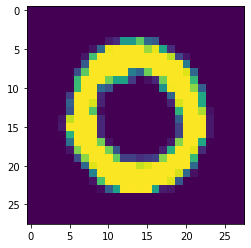

In [2]:
#To start we will load and format the training data in python:
import pandas as pd
trainData = pd.read_csv("./Data/MNIST_train.csv")
train_y = trainData['label'].to_numpy()
train_x = trainData.to_numpy()
#The first column is the label column so we will remove that
train_x = train_x[:,1:train_x.shape[1]]
#turn our data into torch tensors
train_y = torch.from_numpy(train_y)
train_x = torch.from_numpy(train_x)
#We now need to reshape train_x so that it is in the correct format for the image classifier
train_x = train_x.view(train_x.shape[0], 1, int(np.sqrt(train_x.shape[1])), int(np.sqrt(train_x.shape[1])))
#Split into test and train datasets (since the MNIST_test.csv file is unlabeled)
y = torch.zeros(train_y.shape[0], 10).cuda()
for k in range(train_y.shape[0]):
    y[k,train_y[k]] = 1
train_y = y
#Now we'll look an image and write a function that will take a tensor and show the plot of the image
import matplotlib.pyplot as plt

def TImShow(image):
    image = image[0,:,:]
    plt.imshow(image.cpu().detach().numpy())
    plt.show()
TImShow(train_x[1,:,:,:])

But how does a typical conditional GAN work? Skimming the original paper on conditional GANs (https://arxiv.org/pdf/1411.1784.pdf) one can see that conditional information can be provided to the generator simply by passing a vector y to the first layer of the GAN that contains some information on which digit to generate.  First let's try implementing a normal conditional discriminator to see what our results look like (which just involves concatenating the conditional information to the input of the neural net, though we are going to concatenate a little further in the net since the discriminator we are using does not flatten the image until close to the middle of the net). After this we will use a projection discriminator which will use projection to give that information to the discriminator (see ImageToImageTranslation.ipynb or https://arxiv.org/pdf/1802.05637.pdf):

In [3]:
#Again, a lot of these design choices come from https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.leReLU = nn.LeakyReLU(.2)
        #Start with a 90 variable input from the latent space, concatinated with a 10 variable input of conditional information
        #and turn it into 7x7x128 linear vector (we'll reshape this next in the forward pass)
        self.fc1 = nn.Linear(100, 7*7*128)
        #next we need to upsample with a transposed convolution
        self.tConv1 = nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1)
        self.batchNorm1 = nn.BatchNorm2d(128)
        self.tConv2 = nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1)
        self.batchNorm2 = nn.BatchNorm2d(128)
        self.conv1 = nn.Conv2d(128, 1, 7, padding = 3)
        #this must have output dimension equal to the image
        
    def forward(self, x):
        x = self.leReLU(self.fc1(x))
        x = x.view(-1,128,7,7) #working with 7x7 images
        x = self.leReLU(self.batchNorm1(self.tConv1(x))) #upscale to 14x14
        x = self.leReLU(self.batchNorm2(self.tConv2(x))) #upscale to 28x28
        x = torch.tanh(self.conv1(x))
        return x
gen = Generator().cuda()
print(gen)

class Discriminator(nn.Module):
    #Note that exImg will contain and example image which we can get the dimension of NOTE: this should have dimension (1, 1, height, width)
    def __init__(self, exImg):
        super(Discriminator, self).__init__()
        self.inputImg = exImg
        self.conv1 = nn.Conv2d(1, 64, 3, stride = 2, padding = 1)
        self.batchNorm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, stride = 2, padding = 1)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.leReLU = nn.LeakyReLU(.2)
        #Note I found the number of inputs to this layer by experimentation, so I just manually entered the number
        self.fc1 = nn.Linear(3136, 10)
        self.fc2 = nn.Linear(20, 1)
        
        self.V = nn.Linear(10, 10)

    def forward(self, x, y):
        x = self.leReLU(self.conv1(x))
        x = self.batchNorm1(x)
        x = self.leReLU(self.conv2(x))
        x = self.batchNorm2(x)
        # Remember that view reshapes the tensor, so this is a flattening layer since it contains a -1 we will get an output shape of
        # (nSamples, nChannels * number of features (which has changed from the original due to the convolutions and pooling))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        
        temp = self.V(y)
        x = torch.cat((x,y), dim = 1)
        
        x = self.fc2(x)
        
        return x
    #Gets the number of features after all of the dimensionality reduction is applied to x from the convolutions and maxpoolings
    def num_flat_features(self, x):
        # x's shape is originally nSamples, nChannels, Height, Width for images, so we want to compute nChannels * num features = 
        # nChannels * Current Height * Current Width (current referring to after conv and pooling)
        size = x.shape[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
batch_size = 128
exImg = train_x[0,:,:,:].view(1,1,28,28)
dis = Discriminator(exImg).cuda()
print(dis)

Generator(
  (leReLU): LeakyReLU(negative_slope=0.2)
  (fc1): Linear(in_features=100, out_features=6272, bias=True)
  (tConv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchNorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tConv2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)
Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leReLU): LeakyReLU(negative_slope=0.2)
  (fc1): Linear(in_features=313

I will be using Wasserstein loss to train this (see my first biweekly report):

The generator's first attempt at generating an image: 
Conditioned on:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


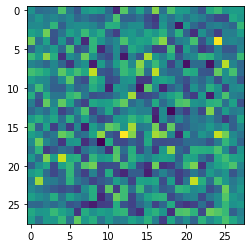

[2,   328] loss: 4.382
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')


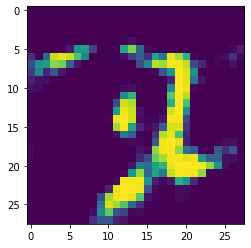

[4,   328] loss: 8.757
Conditioned on:
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


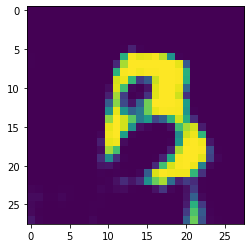

[6,   328] loss: 10.464
Conditioned on:
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')


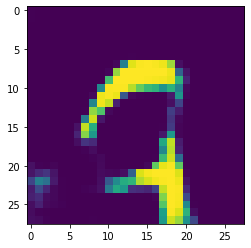

[8,   328] loss: 10.092
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


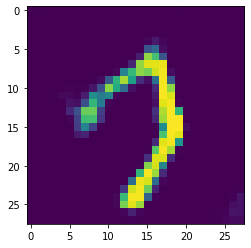

[10,   328] loss: 10.082
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


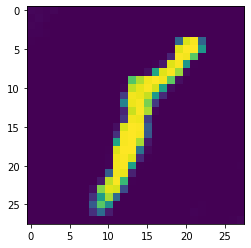

[12,   328] loss: 10.646
Conditioned on:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


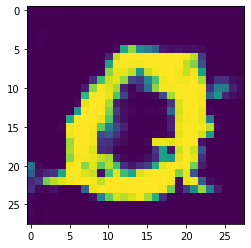

[14,   328] loss: 10.923
Conditioned on:
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


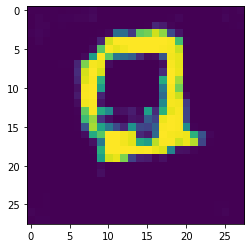

[16,   328] loss: 11.242
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


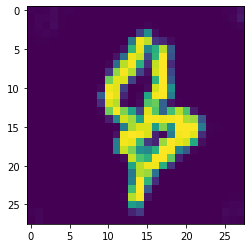

[18,   328] loss: 11.530
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')


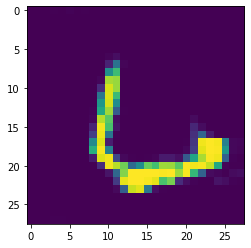

[20,   328] loss: 11.725
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


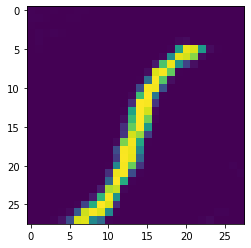

[22,   328] loss: 11.592
Conditioned on:
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


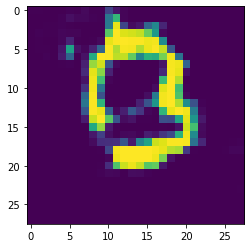

[24,   328] loss: 11.832
Conditioned on:
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')


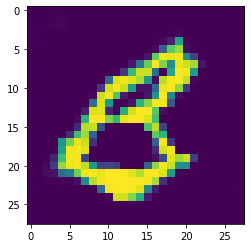

[26,   328] loss: 11.970
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


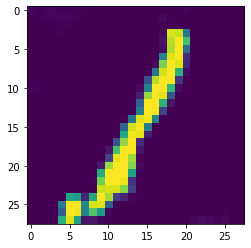

[28,   328] loss: 12.038
Conditioned on:
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


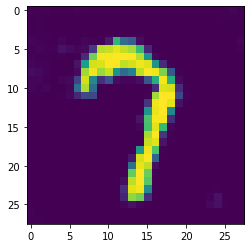

[30,   328] loss: 12.124
Conditioned on:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


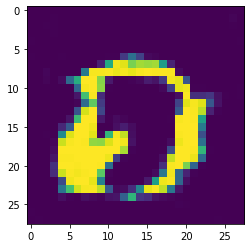

[32,   328] loss: 12.120
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


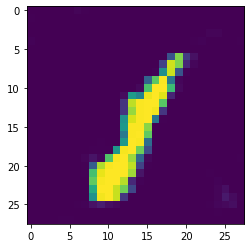

[34,   328] loss: 12.020
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')


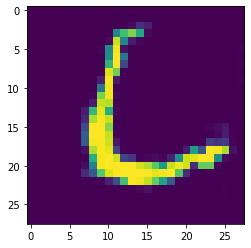

[36,   328] loss: 12.245
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


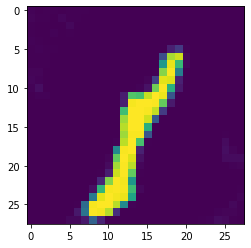

[38,   328] loss: 12.237
Conditioned on:
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')


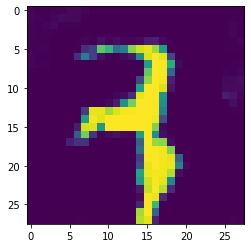

[40,   328] loss: 12.159
Conditioned on:
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


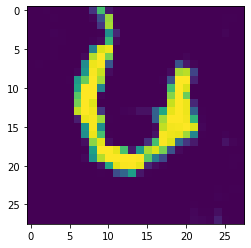

Done traininig


In [4]:
def getRealSamples(data, target, batch_size):
    temp = torch.randperm(batch_size)
    result = data[temp, :, :, :]
    #rescale to match generator, normal grey scale ranges from [0,255], so to do this rescale we will subtrack by the mid point and divide by the mid point 
    #(this will force all the values to be between -1 and 1)
    result = result.float()
    result = (result - 255/2)/(255/2)
    tar = target[temp]
    return result.cuda(), tar.cuda()

#define our two optimizers
learning_rate = 5e-5
#Use two separate RMSProp optimizers, one for the generator and one for the discriminator
gOptimizer = torch.optim.RMSprop(gen.parameters(), lr=learning_rate)
dOptimizer = torch.optim.RMSprop(dis.parameters(), lr=learning_rate)
#Now we will define the training loop:
epochs = 40
batchesPerEpoch = int(np.floor(train_x.shape[0]/batch_size))
for epoch in range(epochs):
    running_gen_loss = 0
    
    for i in range(batchesPerEpoch):
        #number of extra times that we will train the critic
        criticConst = 5
        for j in range(criticConst):
            #set the gradients of the critic to zero
            dOptimizer.zero_grad()
            #generate a mini batch of gaussian noise (only 90 of the 100 inputs are random, the rest are conditional information)
            genMiniBatch = torch.rand(batch_size, 90).cuda()
            #get a minibatch of the real data
            realMiniBatch, y = getRealSamples(train_x, train_y, batch_size)
            #Start by training the discriminator
            #Get Dx, the discriminator when applied to the minibatch of real data
            Dx = dis(realMiniBatch, y.float())
            #calculate the loss associated with this step
            dxLoss = -1*torch.mean(Dx)
            #find the gradients for this step
            dxLoss.backward()
            #generate fake images
            genMiniBatch = torch.cat((genMiniBatch, y), dim = 1)
            Gz = gen(genMiniBatch.float())
            #apply the discriminator to fake images
            DGz = dis(Gz.view(batch_size, 1, 28, 28), y)
            #Find the loss associated with this step
            dgzLoss = 1*torch.mean(DGz)
            #Accumulate the gradients for this half of the loss
            dgzLoss.backward()
            #set the total loss as the sum of our two previous losses
            dLoss = dgzLoss+dxLoss
            dOptimizer.step()
            #weight clipping. I used https://discuss.pytorch.org/t/set-constraints-on-parameters-or-layers/23620/7 as a reference
            #it appears that j.data will allow us to modify non-leaf nodes of our computational graph despite the fact that they require gradients. 
            #It also appears that this feature is depreciated, and it shouldn't be used until after our optimizer has taken a step because it might 
            #mess with the backpropogation.
            #Note: I found the .clamp_ function does exactly what one would think (it makes sure that all the values of a tensor are within the given range) 
            #and the _ denotes that the operation is an inplace operation.
            for k in dis.parameters():
                k.data.clamp_(-.1,.1)
        
        
        #set the generator's gradients to zero
        gOptimizer.zero_grad()
        realMiniBatch, y = getRealSamples(train_x, train_y, batch_size*2)
        genMiniBatch = torch.rand(batch_size*2, 90).cuda()
        genMiniBatch = torch.cat((genMiniBatch, y), dim = 1)
        #use the generator to make a new batch of images (even though we have already computed this we need to recompute it for pytorch to understand 
        #how to backpropogate)
        Gz = gen(genMiniBatch.float())
        #apply the discriminator to the generated images
        DGz = dis(Gz.view(batch_size*2, 1, 28, 28), y)
        #calculate the loss
        gLoss = -1*torch.mean(DGz)
        #accumulate the gradients
        gLoss.backward()
        gOptimizer.step()
        if epoch == 0 and i == 0:
            print("The generator's first attempt at generating an image: ")
            print("Conditioned on:")
            print(y[0])
            Gz = Gz.view(batch_size*2,1,28,28)
            TImShow(Gz[0,:,:,:])
        # print statistics and image
        running_gen_loss += gLoss.item()
        if i == batchesPerEpoch-1 and epoch%2 == 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_gen_loss/batchesPerEpoch))
            print("Conditioned on:")
            print(y[0])
            Gz = Gz.view(batch_size*2,1,28,28)
            TImShow(Gz[0,:,:,:])
                
print("Done traininig")

Now let's try this with the projection discriminator:

In [5]:
#Again, a lot of these design choices come from https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.leReLU = nn.LeakyReLU(.2)
        #Start with a 90 variable input from the latent space, concatinated with a 10 variable input of conditional information
        #and turn it into 7x7x128 linear vector (we'll reshape this next in the forward pass)
        self.fc1 = nn.Linear(100, 7*7*128)
        #next we need to upsample with a transposed convolution
        self.tConv1 = nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1)
        self.batchNorm1 = nn.BatchNorm2d(128)
        self.tConv2 = nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1)
        self.batchNorm2 = nn.BatchNorm2d(128)
        self.conv1 = nn.Conv2d(128, 1, 7, padding = 3)
        #this must have output dimension equal to the image
        
    def forward(self, x):
        x = self.leReLU(self.fc1(x))
        x = x.view(-1,128,7,7) #working with 7x7 images
        x = self.leReLU(self.batchNorm1(self.tConv1(x))) #upscale to 14x14
        x = self.leReLU(self.batchNorm2(self.tConv2(x))) #upscale to 28x28
        x = torch.tanh(self.conv1(x))
        return x
gen = Generator().cuda()
print(gen)

#This parameter method is for the V matrix in the projection inner product (so we can actually train it)
from torch.nn.parameter import Parameter
# Define the critic/discriminator model
class Discriminator(nn.Module):
    #Note that exImg will contain and example image which we can get the dimension of NOTE: this should have dimension (1, 1, height, width)
    def __init__(self, exImg):
        super(Discriminator, self).__init__()
        # The article uses same padding, which is not trivial to implement in pytorch. We will use the padding function with 
        #p = (filter size - 1)/2 = 1 to get same padding
        self.inputImg = exImg
        self.conv1 = nn.Conv2d(1, 64, 3, stride = 2, padding = 1)
        self.batchNorm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, stride = 2, padding = 1)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.leReLU = nn.LeakyReLU(.2)
        #Note I found the number of inputs to this layer by experimentation, so I just manually entered the number
        self.fc1 = nn.Linear(3136, 10)
        self.fc2 = nn.Linear(10, 1)
        
        self.V = Parameter(torch.zeros(10,10))
        self.V = nn.init.xavier_uniform_(self.V) #xavier uniform is an arbirary choice, perhaps there's a better initialization method
        self.V = self.V

    def forward(self, x, y):
        x = self.leReLU(self.conv1(x))
        x = self.batchNorm1(x)
        x = self.leReLU(self.conv2(x))
        x = self.batchNorm2(x)
        # Remember that view reshapes the tensor, so this is a flattening layer since it contains a -1 we will get an output shape of
        # (nSamples, nChannels * number of features (which has changed from the original due to the convolutions and pooling))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        
        #project conditional info: (used https://github.com/MingtaoGuo/sngan_projection_TensorFlow as a guide)
        temp = torch.matmul(y,self.V)
        temp = torch.sum(temp * x, dim=1)
        
        x = self.leReLU(self.fc2(x))
        x = x + temp.view(x.shape)
        
        return x
    #Gets the number of features after all of the dimensionality reduction is applied to x from the convolutions and maxpoolings
    def num_flat_features(self, x):
        # x's shape is originally nSamples, nChannels, Height, Width for images, so we want to compute nChannels * num features = 
        # nChannels * Current Height * Current Width (current referring to after conv and pooling)
        size = x.shape[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
batch_size = 128
exImg = train_x[0,:,:,:].view(1,1,28,28)
dis = Discriminator(exImg).cuda()
print(dis)

Generator(
  (leReLU): LeakyReLU(negative_slope=0.2)
  (fc1): Linear(in_features=100, out_features=6272, bias=True)
  (tConv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchNorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tConv2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)
Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leReLU): LeakyReLU(negative_slope=0.2)
  (fc1): Linear(in_features=313

The generator's first attempt at generating an image: 
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


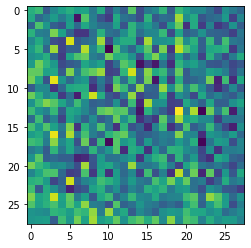

[2,   328] loss: -1.153
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


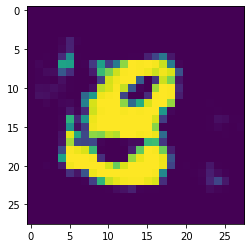

[4,   328] loss: -1.729
Conditioned on:
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


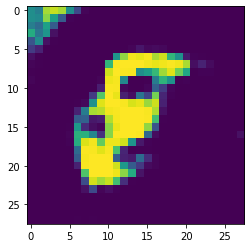

[6,   328] loss: -3.428
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


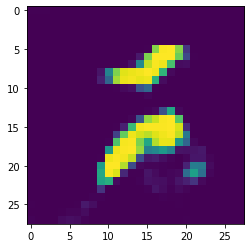

[8,   328] loss: -4.673
Conditioned on:
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


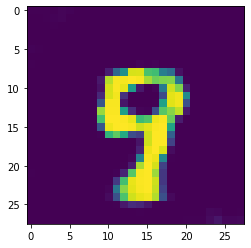

[10,   328] loss: -2.795
Conditioned on:
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')


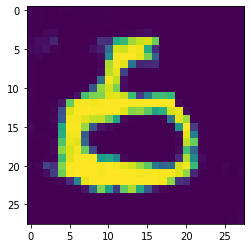

[12,   328] loss: -2.552
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


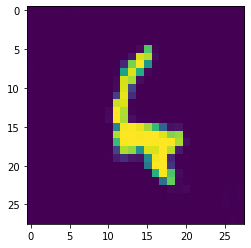

[14,   328] loss: -2.242
Conditioned on:
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')


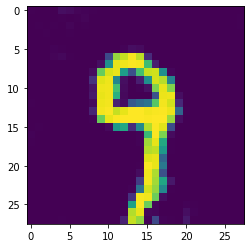

[16,   328] loss: -2.233
Conditioned on:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


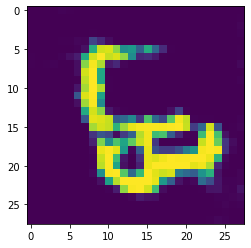

[18,   328] loss: -1.804
Conditioned on:
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')


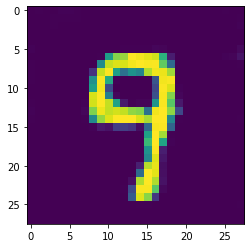

[20,   328] loss: -1.744
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


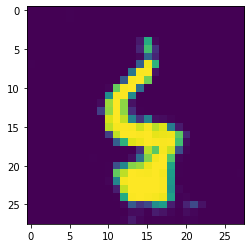

[22,   328] loss: -1.723
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')


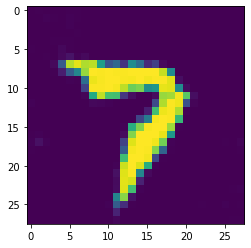

[24,   328] loss: -1.925
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


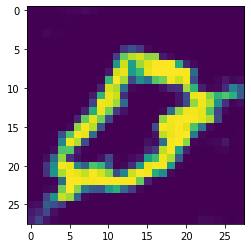

[26,   328] loss: -1.743
Conditioned on:
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')


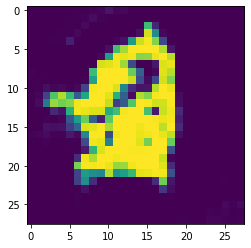

[28,   328] loss: -1.714
Conditioned on:
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')


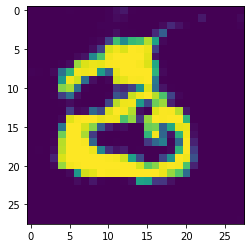

[30,   328] loss: -1.564
Conditioned on:
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')


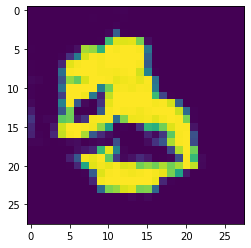

[32,   328] loss: -1.667
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')


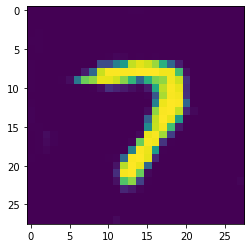

[34,   328] loss: -1.746
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')


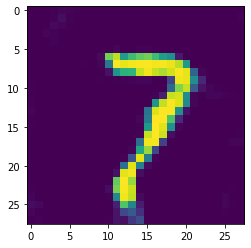

[36,   328] loss: -1.733
Conditioned on:
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')


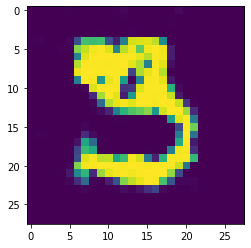

[38,   328] loss: -1.667
Conditioned on:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


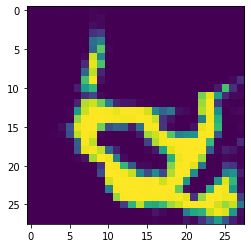

[40,   328] loss: -1.562
Conditioned on:
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')


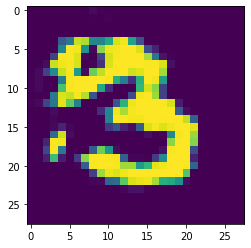

Done traininig


In [6]:
def getRealSamples(data, target, batch_size):
    temp = torch.randperm(batch_size)
    result = data[temp, :, :, :]
    #rescale to match generator, normal grey scale ranges from [0,255], so to do this rescale we will subtrack by the mid point and divide by the mid point 
    #(this will force all the values to be between -1 and 1)
    result = result.float()
    result = (result - 255/2)/(255/2)
    tar = target[temp]
    return result.cuda(), tar.cuda()

#define our two optimizers
learning_rate = 5e-5
#Use two separate RMSProp optimizers, one for the generator and one for the discriminator
gOptimizer = torch.optim.RMSprop(gen.parameters(), lr=learning_rate)
dOptimizer = torch.optim.RMSprop(dis.parameters(), lr=learning_rate)
#Now we will define the training loop:
epochs = 40
batchesPerEpoch = int(np.floor(train_x.shape[0]/batch_size))
for epoch in range(epochs):
    running_gen_loss = 0
    
    for i in range(batchesPerEpoch):
        #number of extra times that we will train the critic
        criticConst = 5
        for j in range(criticConst):
            #set the gradients of the critic to zero
            dOptimizer.zero_grad()
            #generate a mini batch of gaussian noise (only 90 of the 100 inputs are random, the rest are conditional information)
            genMiniBatch = torch.rand(batch_size, 90).cuda()
            #get a minibatch of the real data
            realMiniBatch, y = getRealSamples(train_x, train_y, batch_size)
            #Start by training the discriminator
            #Get Dx, the discriminator when applied to the minibatch of real data
            Dx = dis(realMiniBatch, y.float())
            #calculate the loss associated with this step
            dxLoss = -1*torch.mean(Dx)
            #find the gradients for this step
            dxLoss.backward()
            #generate fake images
            genMiniBatch = torch.cat((genMiniBatch, y), dim = 1)
            Gz = gen(genMiniBatch.float())
            #apply the discriminator to fake images
            DGz = dis(Gz.view(batch_size, 1, 28, 28), y)
            #Find the loss associated with this step
            dgzLoss = 1*torch.mean(DGz)
            #Accumulate the gradients for this half of the loss
            dgzLoss.backward()
            #set the total loss as the sum of our two previous losses
            dLoss = dgzLoss+dxLoss
            dOptimizer.step()
            #weight clipping. I used https://discuss.pytorch.org/t/set-constraints-on-parameters-or-layers/23620/7 as a reference
            #it appears that j.data will allow us to modify non-leaf nodes of our computational graph despite the fact that they require gradients. 
            #It also appears that this feature is depreciated, and it shouldn't be used until after our optimizer has taken a step because it might 
            #mess with the backpropogation.
            #Note: I found the .clamp_ function does exactly what one would think (it makes sure that all the values of a tensor are within the given range) 
            #and the _ denotes that the operation is an inplace operation.
            for k in dis.parameters():
                k.data.clamp_(-.1,.1)
        
        
        #set the generator's gradients to zero
        gOptimizer.zero_grad()
        realMiniBatch, y = getRealSamples(train_x, train_y, batch_size*2)
        
        genMiniBatch = torch.rand(batch_size*2, 90).cuda()
        genMiniBatch = torch.cat((genMiniBatch, y), dim = 1)
        #use the generator to make a new batch of images (even though we have already computed this we need to recompute it for pytorch to understand 
        #how to backpropogate)
        Gz = gen(genMiniBatch.float())
        #apply the discriminator to the generated images
        DGz = dis(Gz.view(batch_size*2, 1, 28, 28), y)
        #calculate the loss
        gLoss = -1*torch.mean(DGz)
        #accumulate the gradients
        gLoss.backward()
        gOptimizer.step()
        if epoch == 0 and i == 0:
            print("The generator's first attempt at generating an image: ")
            print("Conditioned on:")
            print(y[0])
            Gz = Gz.view(batch_size*2,1,28,28)
            TImShow(Gz[0,:,:,:])
        # print statistics and image
        running_gen_loss += gLoss.item()
        if i == batchesPerEpoch-1 and epoch%2 == 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_gen_loss/batchesPerEpoch))
            print("Conditioned on:")
            print(y[0])
            Gz = Gz.view(batch_size*2,1,28,28)
            TImShow(Gz[0,:,:,:])
                
print("Done traininig")

It looks like neither of these methods are converging quickly, though there are some interesting differences (for instance the projection GAN's generator's loss is negative which suggests that the generator is more easily able to fool this discriminator). It is worth noting that my first setup is not exactly what the paper suggests (they use a different layer type than convolution for the discriminator, and they make the concatenation of the conditional information toward the beginning of the process. What I'm doing is a lot closer to cGANs with hidden concatenation (https://arxiv.org/pdf/1605.05396.pdf, or see figure 1 from https://arxiv.org/pdf/1802.05637.pdf). I think both of these will converge eventually, but it seems to be rather slow, and I'm not really sure if I can draw any substantial conclusions just by looking at the images each generates. One idea that I had to possibly speed up the convergence was to add another loss to the equation. Imagine that we had a pre trained neural net for classification, if we ran the generated samples through that net and observed the difference between its predicted class and the class we were trying to generate we could get a loss for the network. Basically, rather than just tricking the discriminator we could try to also trick a classification neural net. I want to try to implement this to see if it will help at all. Again I will start by reusing a neural net I made in the first week (just the first neural net I made in Pytorch since it seemed to perform fine for this task). I will apply MSE loss with a scaling to the output of the pre trained classifier (the scaling is mostly because we are using Wasserstein loss for the discriminator loss, which is unconstrained, so the scaling will be there to make the model consider both losses, not just the Wasserstein loss). Making this explicit, if $G(z|y)$ is the output of our generator conditioned on a class $y$ (in the form of a one hot encoded vector), and $\phi(G(z|Y))$ is the classifier net evaluated on the generated images, we would like to minimize $\lambda*1/m\sum_{i=0}^{m}(\phi(G(z_i|y_i))-y_i)^2$ where $m$ is the batch size and $\lambda$ is a scaling value. This loss should be minimized only when training the generator (there is no need to calculate it when training the discriminator), and it should be minimized in conjunction with the Wasserstein discriminator loss. Implementing this (using code from my first biweekly report): 

In [8]:
trainData = pd.read_csv("./Data/MNIST_train.csv")
train_y = trainData['label'].to_numpy()
train_x = trainData.to_numpy()
#The first column is the label column so we will remove that
train_x = train_x[:,1:train_x.shape[1]]
#turn our data into torch tensors
train_y = torch.from_numpy(train_y)
train_x = torch.from_numpy(train_x)
#We now need to reshape train_x so that it is in the correct format for the image classifier
train_x = train_x.view(train_x.shape[0], 1, int(np.sqrt(train_x.shape[1])), int(np.sqrt(train_x.shape[1])))
#Split into test and train datasets (since the MNIST_test.csv file is unlabeled)
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1, random_state=4)


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(400, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # Remember that view reshapes the tensor, so this is a flattening layer since it contains a -1 we will get an output shape of 
        # (nSamples, nChannels * number of features (which has changed from the original due to the convolutions and pooling))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim = 1)
        return x
    #Gets the number of features after all of the dimensionality reduction is applied to x from the convolutions and maxpoolings
    def num_flat_features(self, x):
        # x's shape is originally nSamples, nChannels, Height, Width for images, so we want to compute nChannels * num features = nChannels * Current Height * Current Width
        # (current referring to after conv and pooling)
        size = x.shape[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net().cuda()

In [10]:
criterion = nn.CrossEntropyLoss()
#we will use the adam optimizer for this
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#Train the model:
#The number of epochs to do on the whole dataset
epochs = 10
#Note that this training loop was inspired by the documentation found here:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
for epoch in range(epochs):
    #running_loss (from the pytorch documentation) will keep track of the average loss as we train
    running_loss = 0.0
    for i in range(train_x.shape[0]):
        #set the gradients to zero (or else we'll just keep adding to gradients)
        optimizer.zero_grad()
        #create the input image constructed from a single image, we have to reshape it (using veiw()) to make it usable by our neural network
        input = train_x[i,:,:,:].view(1,1,28,28).cuda()
        outputs = net(input.float())
        
        #our loss is calculated using cross entropy, we reshape train_y[i] here because it needs to have the same first dimension as outputs
        loss = criterion(outputs, train_y[i].view(1).cuda())
        #calculate the gradients and take a step using the optimizer
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20000 == 19999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20000))
            running_loss = 0.0

print('Finished Training')

[1, 20000] loss: 1.717
[2, 20000] loss: 1.501
[3, 20000] loss: 1.491
[4, 20000] loss: 1.488
[5, 20000] loss: 1.484
[6, 20000] loss: 1.482
[7, 20000] loss: 1.482
[8, 20000] loss: 1.482
[9, 20000] loss: 1.482
[10, 20000] loss: 1.480
Finished Training


In [11]:
#Now that we've trained the model we can look at our accuracy on the testset
predicted = np.zeros((test_x.shape[0], 10))
running_loss = 0
for i in range(test_x.shape[0]):
    input = test_x[i,:,:,:].view(1,1,28,28).cuda()
    outputs = net(input.float())
    
    loss = criterion(outputs, test_y[i].view(1).cuda())
    predicted[i,:] = outputs.cpu().detach().numpy()
    running_loss += loss.item()
print("The loss on the test set was: " + str(running_loss/test_x.shape[0]))
correct = 0
for i in range(predicted.shape[0]):
    pred = np.argmax(predicted[i,:])
    if int(pred) == int(test_y[i]):
        correct += 1
print("The accuracy on the test set was: " + str(correct/predicted.shape[0]))

The loss on the test set was: 1.4849240355832236
The accuracy on the test set was: 0.9761904761904762


Reload the data so that it's not split into a test and train set:

In [13]:
trainData = pd.read_csv("./Data/MNIST_train.csv")
train_y = trainData['label'].to_numpy()
train_x = trainData.to_numpy()
#The first column is the label column so we will remove that
train_x = train_x[:,1:train_x.shape[1]]
#turn our data into torch tensors
train_y = torch.from_numpy(train_y)
train_x = torch.from_numpy(train_x)
#We now need to reshape train_x so that it is in the correct format for the image classifier
train_x = train_x.view(train_x.shape[0], 1, int(np.sqrt(train_x.shape[1])), int(np.sqrt(train_x.shape[1])))
#Split into test and train datasets (since the MNIST_test.csv file is unlabeled)
y = torch.zeros(train_y.shape[0], 10).cuda()
for k in range(train_y.shape[0]):
    y[k,train_y[k]] = 1
train_y = y

The generator's first attempt at generating an image: 
Conditioned on:
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


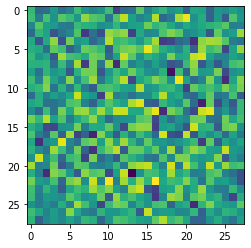

[2,   328] loss: -0.298
Conditioned on:
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')


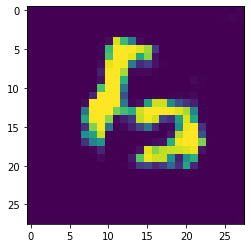

[4,   328] loss: -1.759
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')


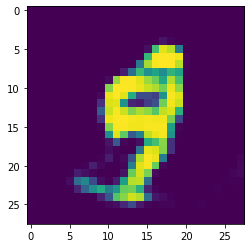

[6,   328] loss: -3.172
Conditioned on:
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')


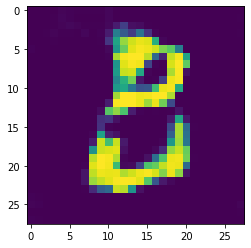

[8,   328] loss: -2.364
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')


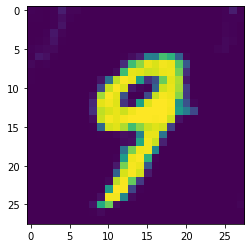

[10,   328] loss: -2.342
Conditioned on:
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')


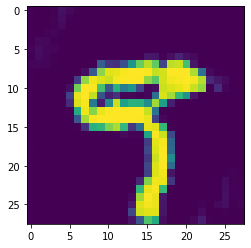

[12,   328] loss: -2.120
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


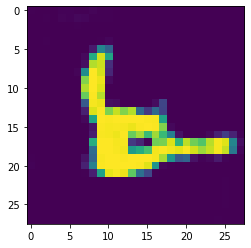

[14,   328] loss: -2.168
Conditioned on:
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


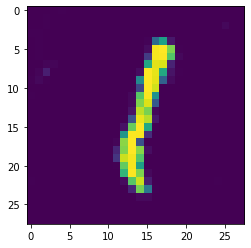

[16,   328] loss: -2.700
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')


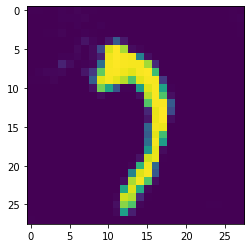

[18,   328] loss: -2.585
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


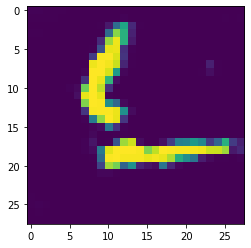

[20,   328] loss: -2.159
Conditioned on:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


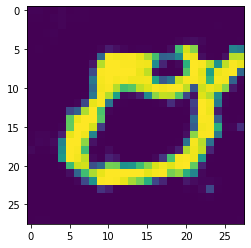

[22,   328] loss: -2.197
Conditioned on:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


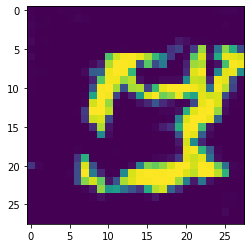

[24,   328] loss: -2.371
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


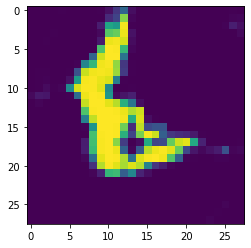

[26,   328] loss: -2.342
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


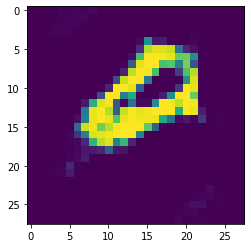

[28,   328] loss: -1.624
Conditioned on:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


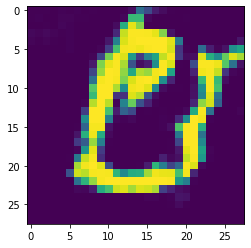

[30,   328] loss: -1.836
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')


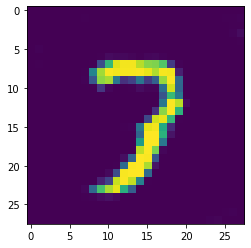

[32,   328] loss: -1.566
Conditioned on:
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')


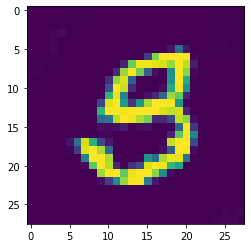

[34,   328] loss: -1.475
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')


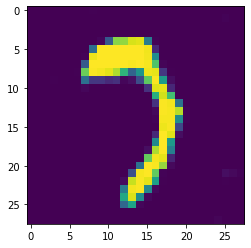

[36,   328] loss: -2.213
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')


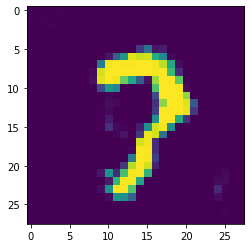

[38,   328] loss: -1.912
Conditioned on:
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


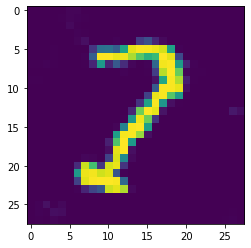

[40,   328] loss: -1.991
Conditioned on:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


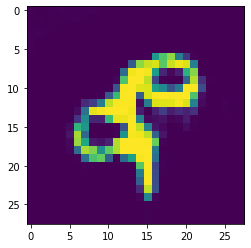

Done traininig


In [25]:
batch_size = 128
exImg = train_x[0,:,:,:].view(1,1,28,28)
#reinit the discriminator and generator
dis = Discriminator(exImg).cuda()
gen = Generator().cuda()
net.eval()
#define our two optimizers
learning_rate = 5e-5
#Use two separate RMSProp optimizers, one for the generator and one for the discriminator
gOptimizer = torch.optim.RMSprop(gen.parameters(), lr=learning_rate)
dOptimizer = torch.optim.RMSprop(dis.parameters(), lr=learning_rate)

predCriterion = nn.MSELoss()
#Now we will define the training loop:
epochs = 40
batchesPerEpoch = int(np.floor(train_x.shape[0]/batch_size))
for epoch in range(epochs):
    running_gen_loss = 0
    
    for i in range(batchesPerEpoch):
        #number of extra times that we will train the critic
        criticConst = 5
        for j in range(criticConst):
            #set the gradients of the critic to zero
            dOptimizer.zero_grad()
            #generate a mini batch of gaussian noise (only 90 of the 100 inputs are random, the rest are conditional information)
            genMiniBatch = torch.rand(batch_size, 90).cuda()
            #get a minibatch of the real data
            realMiniBatch, y = getRealSamples(train_x, train_y, batch_size)
            #Start by training the discriminator
            #Get Dx, the discriminator when applied to the minibatch of real data
            Dx = dis(realMiniBatch, y.float())
            #calculate the loss associated with this step
            dxLoss = -1*torch.mean(Dx)
            #find the gradients for this step
            dxLoss.backward()
            #generate fake images
            genMiniBatch = torch.cat((genMiniBatch, y), dim = 1)
            Gz = gen(genMiniBatch.float())
            #apply the discriminator to fake images
            DGz = dis(Gz.view(batch_size, 1, 28, 28), y)
            #Find the loss associated with this step
            dgzLoss = 1*torch.mean(DGz)
            #Accumulate the gradients for this half of the loss
            dgzLoss.backward()
            
            #set the total loss as the sum of our two previous losses
            dLoss = dgzLoss+dxLoss
            dOptimizer.step()
            #weight clipping. I used https://discuss.pytorch.org/t/set-constraints-on-parameters-or-layers/23620/7 as a reference
            #it appears that j.data will allow us to modify non-leaf nodes of our computational graph despite the fact that they require gradients. 
            #It also appears that this feature is depreciated, and it shouldn't be used until after our optimizer has taken a step because it might 
            #mess with the backpropogation.
            #Note: I found the .clamp_ function does exactly what one would think (it makes sure that all the values of a tensor are within the given range) 
            #and the _ denotes that the operation is an inplace operation.
            for k in dis.parameters():
                k.data.clamp_(-.1,.1)
        
        
        #set the generator's gradients to zero
        gOptimizer.zero_grad()
        realMiniBatch, y = getRealSamples(train_x, train_y, batch_size*2)
        
        genMiniBatch = torch.rand(batch_size*2, 90).cuda()
        genMiniBatch = torch.cat((genMiniBatch, y), dim = 1)
        #use the generator to make a new batch of images (even though we have already computed this we need to recompute it for pytorch to understand 
        #how to backpropogate)
        Gz = gen(genMiniBatch.float())
        
        #predict what class our generated images belong to
        predClasses = net(Gz)
        #calculate MSE Loss
        predLoss = predCriterion(predClasses, y)

        #apply the discriminator to the generated images
        DGz = dis(Gz.view(batch_size*2, 1, 28, 28), y)
        #calculate the loss
        gLoss = -1*torch.mean(DGz) + 5*predLoss
        #accumulate the gradients
        gLoss.backward()
        gOptimizer.step()
        if epoch == 0 and i == 0:
            print("The generator's first attempt at generating an image: ")
            print("Conditioned on:")
            print(y[0])
            Gz = Gz.view(batch_size*2,1,28,28)
            TImShow(Gz[0,:,:,:])
        # print statistics and image
        running_gen_loss += gLoss.item()
        if i == batchesPerEpoch-1 and epoch%2 == 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_gen_loss/batchesPerEpoch))
            print("Conditioned on:")
            print(y[0])
            Gz = Gz.view(batch_size*2,1,28,28)
            TImShow(Gz[0,:,:,:])
                
print("Done traininig")

This worked astonishingly well, we have gone from making fairly consistent errors in which digit was generated to making far fewer, and for the errors that we do make one can sort of see why the neural net made those errors. For instance, for epoch 32 it appears that the model generated a 9 when it was supposed to generate a 3, but the 9 looks incredibly similar to a 3 (just with an extraneous connection made in the structure). All of these outputs are either the genuine digit that we conditioned for, or something very similar, and I'm sure that with more training this would be even better.
## Final Thoughts
It seems conditional GANs take a while to converge to the desired behavior (i.e. only generating the digit that we ask for with the conditional information), but we were able to speed this convergence up by including a pretrained neural net for classification in the loss. This was yet another interesting exercise in how loss can be leveraged to get a desired behavior. 
